In [12]:
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification
from tqdm import tqdm
import json
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.model_selection import train_test_split
import imgkit
import easyocr
import torchvision.transforms as T
from pathlib import Path
import matplotlib.pyplot as plt
import os
import cv2
from typing import List
import json
from torchmetrics import Accuracy
from huggingface_hub import notebook_login
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu121
True


In [3]:
%matplotlib inline
pl.seed_everything(42)

Seed set to 42


42

In [4]:
image_dir=Path(r"C:\Users\tharshananth N\appian ai\fintech")

In [5]:
for dir in image_dir.glob("*"):
       class_dir_img=image_dir /dir.name 
       class_dir_img.mkdir(exist_ok=True, parents=True)

In [6]:
dir

WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Utility')

In [7]:
class_dir=list(image_dir.glob("*"))
class_dir

[WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Check'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/ITR_Form 16'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Salary Slip'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Utility')]

In [8]:
image_paths = sorted([p for p in image_dir.glob("*/*.jpg") if p.is_file()])
image_paths

[WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/1.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/10.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/11.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/12.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/13.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/14.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/15.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/16.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/17.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/18.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/19.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/2.jpg'),
 WindowsPath('C:/Users/tharsha

width:768X height:1024


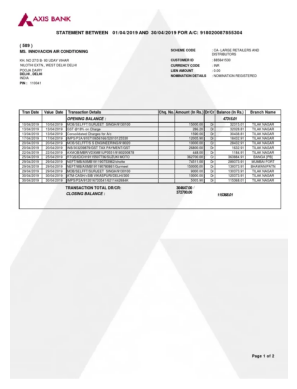

In [9]:
if image_paths:
       try:
              image=Image.open(image_paths[0]).convert('RGB')
              width, height=image.size
              print(f'width:{width}X height:{height}')
              
              plt.imshow(image)
              plt.axis('off')
              plt.show()
       except Exception as e:
            print(f"Error opening image: {e}")
      
else:
       print('no ')

In [10]:
from easyocr import Reader

ini = str(image_paths[0])

reader = Reader(['en'])

ocr_result = reader.readtext(ini)
for bbox, text, confidence in ocr_result:
    print(f"Detected text: {text}, Confidence: {confidence}")

Detected text: AXIS BANK, Confidence: 0.8319232761526623
Detected text: STATEMENT BETWEEN, Confidence: 0.9361189517805588
Detected text: 01/04/2019 AND, Confidence: 0.8127516397534338
Detected text: 30/04/2019 FOR AIC: 918020087855304, Confidence: 0.8613523183586869
Detected text: 589, Confidence: 0.9999821053874435
Detected text: INNOVACION AIR CONDITIONING, Confidence: 0.7370530296358013
Detected text: SCHEME CODE, Confidence: 0.9452615824745251
Detected text: CA- LAAGE ReTAILeRS AND, Confidence: 0.36911374088783994
Detected text: DISTR IBUTORS, Confidence: 0.6505274132768822
Detected text: KARo 27/3 [, Confidence: 0.12105104293729542
Detected text: UDAY VIHAR, Confidence: 0.8133352342979157
Detected text: customeR ID, Confidence: 0.28096742326033863
Detected text: 885841520, Confidence: 0.8044487824660068
Detected text: NILOTHI EXTN_ WEST DELHI DELHI, Confidence: 0.4635272919096972
Detected text: CURRENCY CODE, Confidence: 0.975501066532019
Detected text: POOJA DAIRY, Confidence: 0.

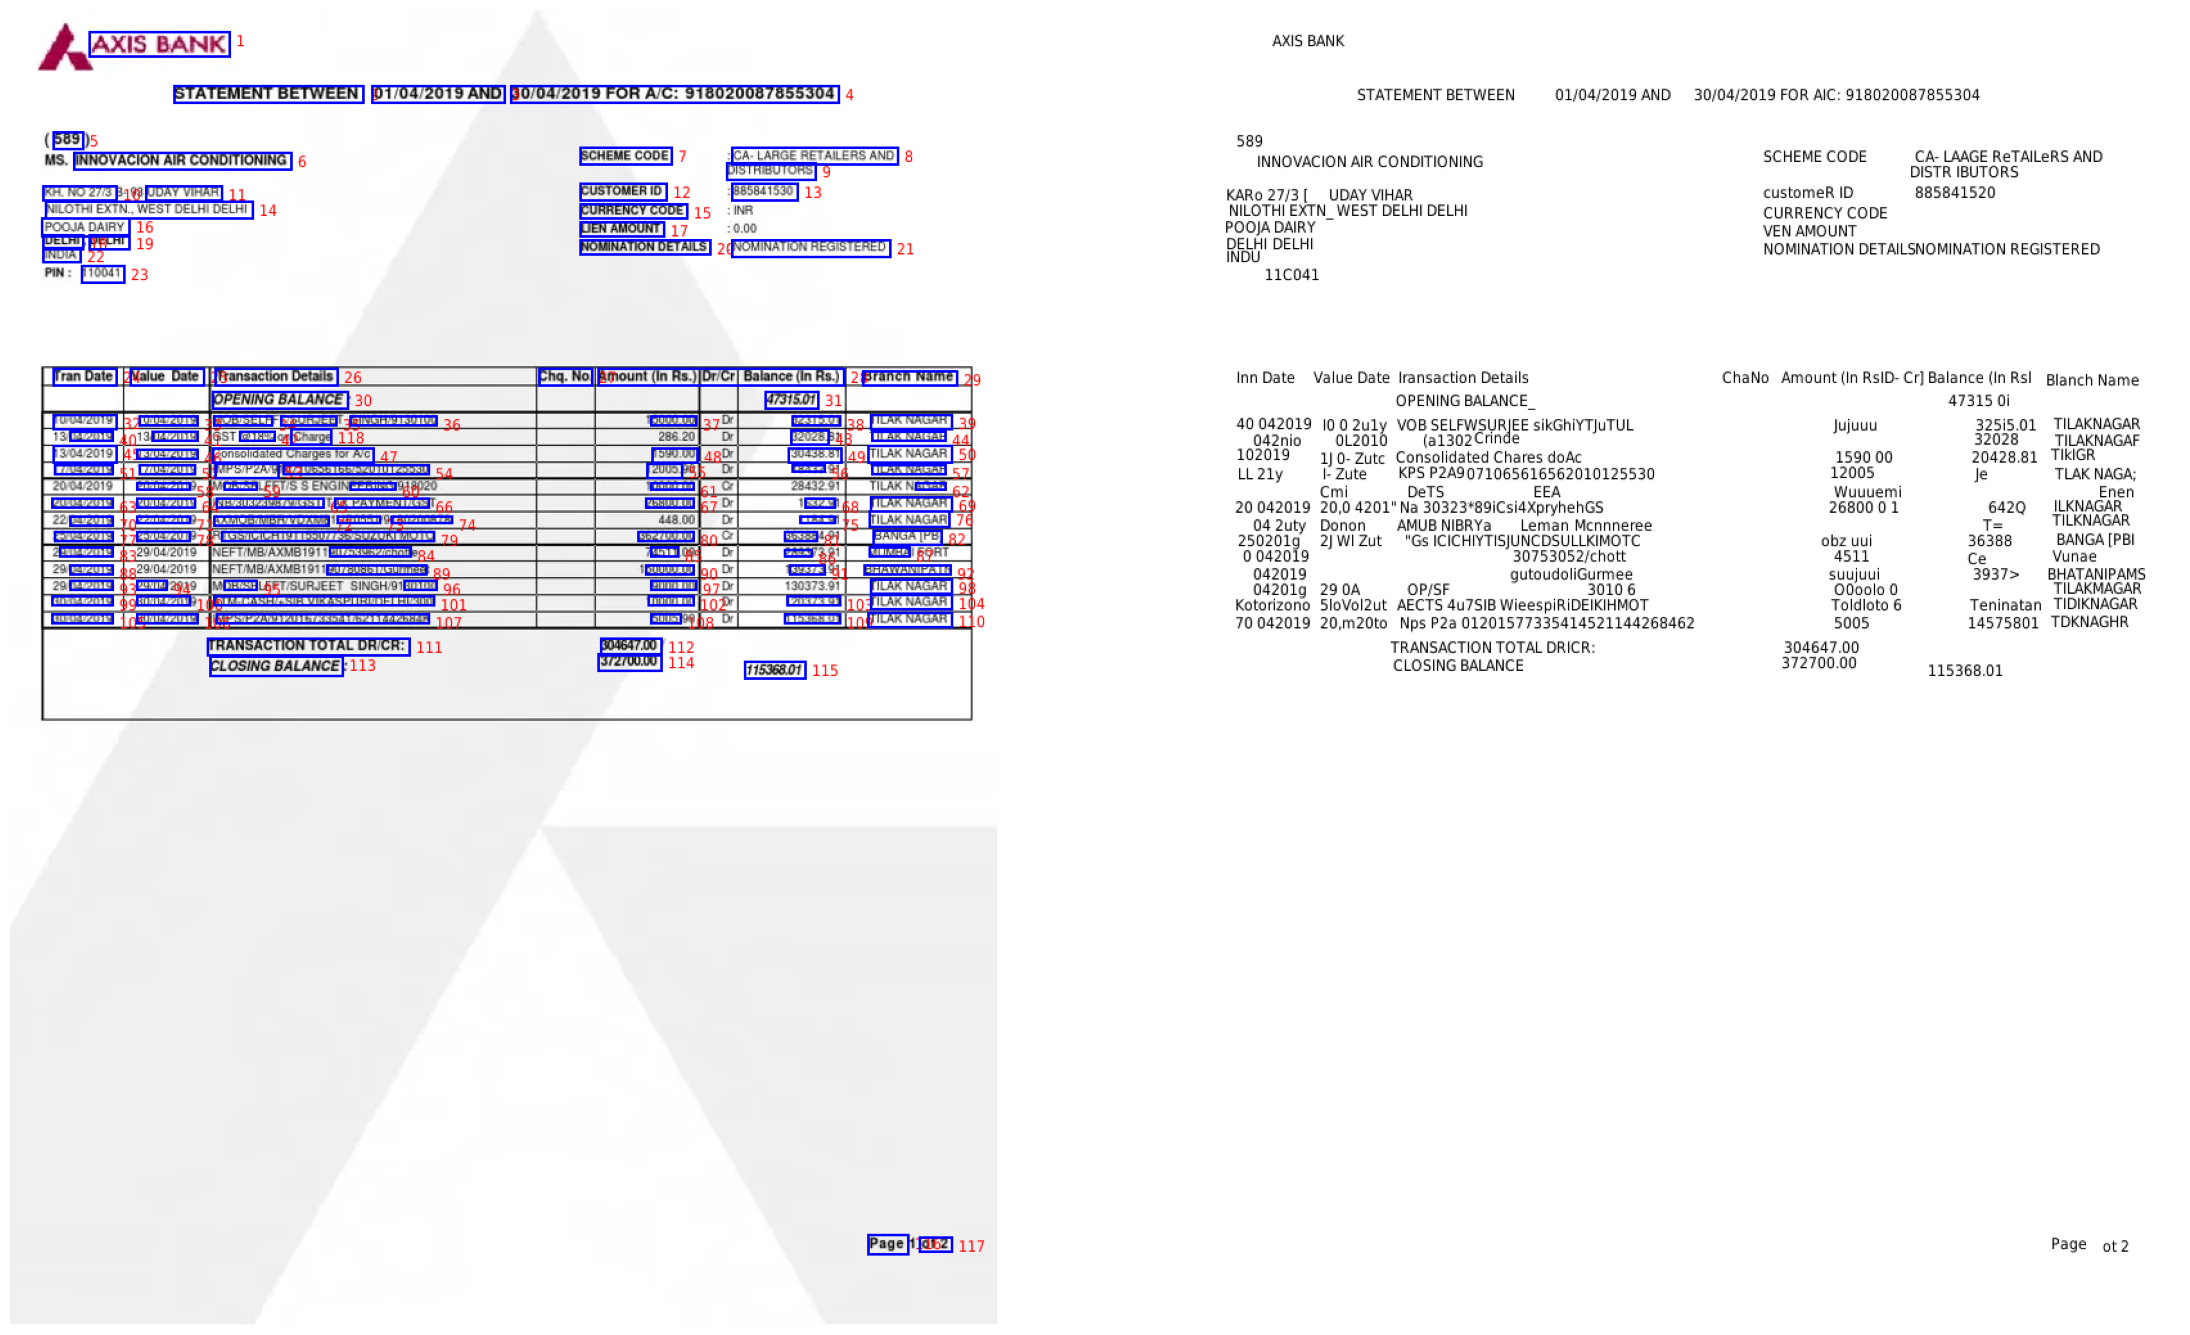

In [11]:
def create_bounding_box(bbox_data):
    xs = []
    ys = []
    for x, y in bbox_data:
        xs.append(x)
        ys.append(y)
 
    left = int(min(xs))
    top = int(min(ys))
    right = int(max(xs))
    bottom = int(max(ys))
 
    return [left, top, right, bottom]
 
font_path = Path(cv2.__path__[0]) / r"C:\Users\tharshananth N\Downloads\DejaVuSansCondensed.ttf"
font = ImageFont.truetype(str(font_path), size=12)
 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 28))
 
left_image = Image.open(ini).convert("RGB")
right_image = Image.new("RGB", left_image.size, (255, 255, 255))
 
left_draw = ImageDraw.Draw(left_image)
right_draw = ImageDraw.Draw(right_image)
 
for i, (bbox, word, confidence) in enumerate(ocr_result):
    box = create_bounding_box(bbox)
 
    left_draw.rectangle(box, outline="blue", width=2)
    left, top, right, bottom = box
 
    left_draw.text((right + 5, top), text=str(i + 1), fill="red", font=font)
    right_draw.text((left, top), text=word, fill="black", font=font)
 
ax1.imshow(left_image)
ax2.imshow(right_image)
ax1.axis("off");
ax2.axis("off");

In [12]:
import cv2
import json
from tqdm import tqdm
from pathlib import Path
import os
import numpy as np  

from easyocr import Reader
reader = Reader(['en'], gpu=True)  

image_paths =  [
    file for file in Path(r"C:\Users\tharshananth N\appian ai\fintech").rglob("*")
    if file.suffix.lower() in {'.png', '.jpg', '.jpeg'}
]
ocr_results = {}

for ini in tqdm(image_paths, desc="Processing Images"):
    try:
        img = cv2.imread(str(ini))
        if img is None:
            print(f"Skipping invalid image: {ini}")
            continue

        ocr_result = reader.readtext(img, batch_size=4)

        ocr_page = []
        for bbox, word, confidence in ocr_result:
            bbox = [list(map(int, coord)) for coord in bbox]  
            ocr_page.append({
                "bbox": bbox,
                "word": word,
                "confidence": float(confidence)  
            })

        ocr_results[str(ini)] = ocr_page

    except Exception as e:
        print(f"Error processing image {ini}: {e}")


Processing Images: 100%|██████████| 415/415 [12:59<00:00,  1.88s/it]


In [13]:
with open("ocr_results.json") as json_file:
      ocr_results = json.load(json_file)


In [13]:
output_file = Path(r"C:\Users\tharshananth N\appian ai\ocr_results.json")

with open(output_file, "w") as json_file:
    json.dump(ocr_results, json_file, indent=4)

print(f"OCR results saved to {output_file}")

OCR results saved to C:\Users\tharshananth N\appian ai\ocr_results.json


In [14]:
output_file = Path(r"C:\Users\tharshananth N\appian ai\ocr_results.json")

with open(output_file, "w") as json_file:
    json.dump(ocr_results, json_file, indent=4)

print(f"OCR results saved to {output_file}")

OCR results saved to C:\Users\tharshananth N\appian ai\ocr_results.json


In [16]:
image_paths = [
    file for file in Path(r"C:\Users\tharshananth N\appian ai\fintech").rglob("*")
    if file.suffix.lower() in {'.png', '.jpg', '.jpeg'}
]
image_paths

[WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/1.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/10.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/11.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/12.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/13.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/14.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/15.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/16.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/17.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/18.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/19.jpg'),
 WindowsPath('C:/Users/tharshananth N/appian ai/fintech/Bank Statement/2.jpg'),
 WindowsPath('C:/Users/tharsha

In [17]:
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False)
tokenizer = LayoutLMv3TokenizerFast.from_pretrained(
    "microsoft/layoutlmv3-base"
)
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

c:\Users\tharshananth N\.conda\envs\fast_gpu\lib\site-packages\transformers\models\layoutlmv3\feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(
c:\Users\tharshananth N\.conda\envs\fast_gpu\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
ini = image_paths[0]
image = Image.open(ini).convert("RGB")
width, height = image.size
 
width_scale = 1000 / width
height_scale = 1000 / height

In [19]:
from pathlib import Path
import json
from typing import List

def scale_bounding_box(box: List[int], width_scale: float = 1.0, height_scale: float = 1.0) -> List[int]:
    """Scales a bounding box by the given width and height factors.

    Args:
        box: A list containing four integers representing the top-left and bottom-right coordinates of the bounding box (e.g., [x1, y1, x2, y2]).
        width_scale: The factor by which to scale the width of the bounding box (default: 1.0).
        height_scale: The factor by which to scale the height of the bounding box (default: 1.0).

    Returns:
        A new list containing the scaled bounding box coordinates.

    Raises:
        ValueError: If the `box` argument is not a list of four elements.
        TypeError: If the elements in the `box` list cannot be multiplied by the scale factors.
    """
    if not isinstance(box, list) or len(box) != 4:
        raise ValueError("Invalid box format. Expected a list of four integers.")

    try:
        return [int(round(x * scale)) for x, scale in zip(box, [width_scale, height_scale, width_scale, height_scale])]
    except TypeError:
        raise TypeError("Invalid data type in box. Expected integers.")

def convert_polygon_to_bbox(polygon: List[List[int]]) -> List[int]:
    """Converts a four-point polygon to a bounding box in [x1, y1, x2, y2] format.

    Args:
        polygon: A list of four points, each represented as [x, y].

    Returns:
        A list containing the bounding box in [x1, y1, x2, y2] format.

    Raises:
        ValueError: If the polygon does not have exactly four points.
    """
    if len(polygon) != 4:
        raise ValueError("Polygon must have exactly four points.")
    
    x_coords = [point[0] for point in polygon]
    y_coords = [point[1] for point in polygon]
    return [min(x_coords), min(y_coords), max(x_coords), max(y_coords)]

def process_ocr_results(json_path: Path, width_scale: float = 1.0, height_scale: float = 1.0):
    """Processes OCR results, scales bounding boxes, and collects words.

    Args:
        json_path: Path to the OCR results JSON file.
        width_scale: Scaling factor for bounding box width.
        height_scale: Scaling factor for bounding box height.
    """
    with json_path.open("r") as f:
        ocr_result = json.load(f)

    words = []
    boxes = []

    for image_path, word_data_list in ocr_result.items():
        for word_data in word_data_list:
            try:
                if isinstance(word_data, dict):
                    bbox = word_data["bbox"]
                    if isinstance(bbox[0], list) and len(bbox) == 4:
                        bbox = convert_polygon_to_bbox(bbox)

                    if not (isinstance(bbox, list) and len(bbox) == 4 and all(isinstance(coord, (int, float)) for coord in bbox)):
                        print(f"Invalid bbox format: {bbox}")
                        continue

                    scaled_box = scale_bounding_box([int(round(float(x))) for x in bbox], width_scale, height_scale)
                    boxes.append(scaled_box)
                    words.append(word_data["word"])
                else:
                    print(f"Warning: Unexpected data type for word_data in {image_path}: {type(word_data)}")
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    return words, boxes

if __name__ == "__main__":
    json_path = Path(r"C:\Users\tharshananth N\appian ai\ocr_results.json")
    words, boxes = process_ocr_results(json_path, width_scale=1.0, height_scale=1.0)
    print(f"Number of words: {len(words)}")
    print(f"Number of bounding boxes: {len(boxes)}")


Number of words: 28042
Number of bounding boxes: 28042


In [43]:
from transformers import LayoutLMv3Processor

In [37]:
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")

c:\Users\tharshananth N\.conda\envs\fast_gpu\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\tharshananth N\.conda\envs\fast_gpu\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tharshananth N\.cache\huggingface\hub\models--microsoft--layoutlmv3-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Develope

In [20]:
encoding = processor(
    image,
    words,
    boxes=boxes,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)
 
print(f"""
input_ids:  {list(encoding["input_ids"].squeeze().shape)}
word boxes: {list(encoding["bbox"].squeeze().shape)}
image data: {list(encoding["pixel_values"].squeeze().shape)}
image size: {image.size}
""")


input_ids:  [512]
word boxes: [512, 4]
image data: [3, 224, 224]
image size: (768, 1024)



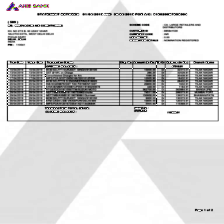

In [21]:
image_data = encoding["pixel_values"][0]
transform = T.ToPILImage()
transform(image_data)

In [22]:
model = LayoutLMv3ForSequenceClassification.from_pretrained(
    "microsoft/layoutlmv3-base", num_labels=2
)

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
train_images, test_images = train_test_split(image_paths, test_size=0.2, random_state=42)

DOCUMENT_CLASSES = sorted(list(map(
    lambda p: p.name,
    image_dir.glob("*")  # Top-level folders represent classes
)))

print("Document Classes:", DOCUMENT_CLASSES)
print("Number of Training Images:", len(train_images))
print("Number of Testing Images:", len(test_images))

Document Classes: ['Bank Statement', 'Check', 'ITR_Form 16', 'Salary Slip', 'Utility']
Number of Training Images: 332
Number of Testing Images: 83


In [24]:
class DocumentClassificationDataset(Dataset):
 
    def __init__(self, image_paths, processor):
        self.image_paths = image_paths
        self.processor = processor
 
    def __len__(self):
        return len(self.image_paths)
 
    def __getitem__(self, item):
 
        image_path = self.image_paths[item]
        json_path = image_path.with_suffix(".json")
        with json_path.open("r") as f:
            ocr_result = json.load(f)
 
            with Image.open(image_path).convert("RGB") as image:
 
                width, height = image.size
                width_scale = 1000 / width
                height_scale = 1000 / height
 
                words = []
                boxes = []
                for row in ocr_result:
                    boxes.append(scale_bounding_box(
                        row["bounding_box"],
                        width_scale,
                        height_scale
                    ))
                    words.append(row["word"])
 
                encoding = self.processor(
                    image,
                    words,
                    boxes=boxes,
                    max_length=512,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt"
                )
 
        label = DOCUMENT_CLASSES.index(image_path.parent.name)
 
        return dict(
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            bbox=encoding["bbox"].flatten(end_dim=1),
            pixel_values=encoding["pixel_values"].flatten(end_dim=1),
            labels=torch.tensor(label, dtype=torch.long)
        )

In [25]:
train_dataset = DocumentClassificationDataset(train_images, processor)
test_dataset = DocumentClassificationDataset(test_images, processor)
 
train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2
)
 
test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2
)

In [26]:
class ModelModule(pl.LightningModule):
    def __init__(self, n_classes:int):
        super().__init__()
        self.model = LayoutLMv3ForSequenceClassification.from_pretrained(
            "microsoft/layoutlmv3-base",
            num_labels=n_classes
        )
        self.model.config.id2label = {k: v for k, v in enumerate(DOCUMENT_CLASSES)}
        self.model.config.label2id = {v: k for k, v in enumerate(DOCUMENT_CLASSES)}
        self.train_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
 
    def forward(self, input_ids, attention_mask, bbox, pixel_values, labels=None):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            bbox=bbox,
            pixel_values=pixel_values,
            labels=labels
        )
 
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("train_loss", output.loss)
        self.log(
            "train_acc",
            self.train_accuracy(output.logits, labels),
            on_step=True,
            on_epoch=True
        )
        return output.loss
 
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("val_loss", output.loss)
        self.log(
            "val_acc",
            self.val_accuracy(output.logits, labels),
            on_step=False,
            on_epoch=True
        )
        return output.loss
 
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.00001) #1e-5
        return optimizer

In [27]:
model_module = ModelModule(len(DOCUMENT_CLASSES))

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
torch.set_float32_matmul_precision("medium")

In [29]:
model_checkpoint = ModelCheckpoint(
    filename="{epoch}-{step}-{val_loss:.4f}", save_last=True, save_top_k=3, monitor="val_loss", mode="min"
)
 
trainer = pl.Trainer(
    accelerator="gpu",
    precision=16,
    devices=1,
    max_epochs=5,
    callbacks=[
        model_checkpoint
    ],
)

c:\Users\tharshananth N\.conda\envs\fast_gpu\lib\site-packages\lightning_fabric\connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model_module, train_data_loader, test_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                                | Params | Mode 
-------------------------------------------------------------------------------
0 | model          | LayoutLMv3ForSequenceClassification | 125 M  | eval 
1 | train_accuracy | MulticlassAccuracy                  | 0      | train
2 | val_accuracy   | MulticlassAccuracy                  | 0      | train
-------------------------------------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
503.686   Total estimated model params size (MB)
2         Modules in train mode
243       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tharshananth N\.conda\envs\fast_gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
